# Reproducing Image results

In [1]:
import pathlib
import os
import pyts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import arff
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import * 

In [3]:
data_path = pathlib.Path('../data')
train_data = arff.loadarff(data_path/'Earthquakes_TRAIN.arff')
valid_data = arff.loadarff(data_path/'Earthquakes_TEST.arff')

In [4]:
def make_dataframe(arff_data):
    """
    Returns formated dataframe from raw arff data
    """
    df = pd.DataFrame(arff_data[0])
    df.columns = [k for k in range(df.shape[1]-1)]+['target']
    df['target'] = df['target'].apply(lambda x: x.decode('ascii')).astype('int')
    return df

In [5]:
train_df = make_dataframe(train_data)
valid_df = make_dataframe(valid_data)

In [6]:
def create_and_mk_dir(root, subdirectory_name):
    """
    Utility to create a directory from `root`:Path `subdirectory_name`:str
    Returns the newly created Path
    """
    new_path = pathlib.Path(root / subdirectory_name)
    new_path.mkdir(exist_ok=True)
    return new_path

In [7]:
def make_directories(method_name, root_path):
    """
    Creates the imagenet-style directories for the given `method_name`:str
    and `root_path`:Path
    root_path
    └── method_name
        ├── train
        │   ├── false
        │   └── true
        └── valid
            ├── false
            └── true

    """
    method_path = create_and_mk_dir(root_path, method_name)
    for phase in ['train', 'valid']:
        phase_path = create_and_mk_dir(method_path, phase)
        for label in ['true', 'false']:
            create_and_mk_dir(phase_path, label)
            
    return method_path

In [8]:
method_path = make_directories('GADF', data_path)

In [9]:
def fill_subdirectories(method_path, phase_name, transformer, df, image_size):
    """
    for a given `transformer`:pyts.image.transformer, and a properly formatted TS dataframe,
    this will fill out the directory structure.
    The files are named according to their index in the data frame and the name of the phase
    """
    image_data = transformer.fit_transform(df[:-1])
    
    true_path = pathlib.Path(method_path / phase_name / 'true')
    false_path = pathlib.Path(method_path / phase_name / 'false')
    
    for image, label, idx in zip(image_data, df.target, df.index):
        if label:
            plt.imsave(str(true_path / '{0}{1}.png'.format(idx, phase_name)), image)
        else:
            plt.imsave(str(false_path / '{0}{1}.png'.format(idx, phase_name)), image)

In [10]:
image_size = 128
transformer = pyts.image.GADF(image_size=image_size)
fill_subdirectories(method_path, 'train', transformer, train_df, image_size)
fill_subdirectories(method_path, 'valid', transformer, valid_df, image_size)

In [11]:
data = (ImageItemList.from_folder(method_path)
       .split_by_folder()
       .label_from_folder()
       .databunch(bs=32))

In [12]:
cnn = create_cnn(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


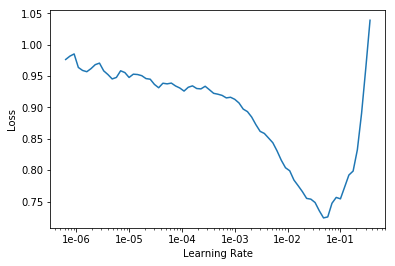

In [13]:
cnn.lr_find(); cnn.recorder.plot()

In [14]:
cnn.fit_one_cycle(5, max_lr=2e-3)

Total time: 00:08
epoch  train_loss  valid_loss  accuracy
1      0.981892    0.630383    0.731884  (00:01)
2      0.832828    0.749238    0.521739  (00:01)
3      0.678769    0.627550    0.710145  (00:01)
4      0.554536    0.618274    0.688406  (00:01)
5      0.463866    0.635496    0.688406  (00:01)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


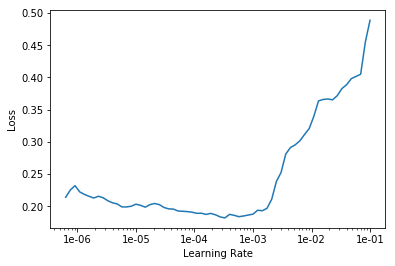

In [15]:
cnn.unfreeze() ; cnn.lr_find() ; cnn.recorder.plot()

In [16]:
cnn.fit_one_cycle(10, max_lr = 5e-5)

Total time: 00:16
epoch  train_loss  valid_loss  accuracy
1      0.212704    0.617267    0.695652  (00:01)
2      0.195428    0.604743    0.710145  (00:01)
3      0.173897    0.601230    0.695652  (00:01)
4      0.164159    0.589560    0.688406  (00:01)
5      0.149065    0.596402    0.681159  (00:01)
6      0.133055    0.601654    0.688406  (00:01)
7      0.123706    0.610229    0.710145  (00:01)
8      0.110135    0.619832    0.702899  (00:01)
9      0.099304    0.640512    0.702899  (00:01)
10     0.091017    0.636186    0.717391  (00:01)



In [17]:
cnn.fit_one_cycle(10, max_lr = 1e-5)

Total time: 00:16
epoch  train_loss  valid_loss  accuracy
1      0.063990    0.634713    0.710145  (00:01)
2      0.071323    0.634235    0.702899  (00:01)
3      0.062687    0.626808    0.702899  (00:01)
4      0.061994    0.621152    0.695652  (00:01)
5      0.059441    0.626844    0.710145  (00:01)
6      0.058340    0.643591    0.710145  (00:01)
7      0.055941    0.648166    0.717391  (00:01)
8      0.052962    0.655709    0.717391  (00:01)
9      0.051215    0.658219    0.724638  (00:01)
10     0.051999    0.675825    0.717391  (00:01)

